# Random Forest Tuning

### 1. Loading libraries and packages:

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### 2. Loading dataset and splitting it into train and test:

In [14]:
df = pd.read_csv('../dataset/creditcard.csv')

In [15]:
# Get features and labels
X = df.drop(['Class'], axis=1).values
y = df['Class'].values

* Here we apply a cross-validation hold-out using 20% of the data for testing the model and 80% for effective training:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [17]:
print(X_train.shape, '-->', y_train.shape)
print(X_test.shape, '-->', y_test.shape)

(227845, 30) --> (227845,)
(56962, 30) --> (56962,)


* Now let's create a grid search for tuning hyperarameters of RandomForestClassifier, que best model in our **Models.ipynb** analysis:

In [18]:
import pickle

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score, auc

#### Code for SVM kernel RBF:

In [19]:
grid_steps_svm = [('scaller',  StandardScaler()),
    ('classifier', SVC(kernel = 'rbf', random_state = 7, probability=True))]

In [20]:
pipeline_svm = Pipeline(grid_steps_svm)

In [21]:
param_grid_svm = {
    'classifier__C': [1, 10, 100],
    'classifier__gamma': [1e-3, 1e-4]
}

#### Code for Random Forest:

In [7]:
grid_steps = [('scaller', StandardScaler()), 
         ('classifier', RandomForestClassifier())]

In [8]:
pipeline = Pipeline(grid_steps)

In [9]:
param_grid = {
    'classifier__n_estimators': [200, 300, 500, 600],
    'classifier__max_depth': [2, 3, 5],
    'classifier__criterion': ['gini', 'entropy']
}

### 3. Here we need to focus on *recall* metric, because we want the least amount of false negative results possible:

In [10]:
search = GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring='recall') # by defaul it creates a 5-fold cross-validation
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaller', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [2, 3, 5],
                         'classifier__n_estimators': [200, 300, 500, 600]},
             scoring='recall')

In [11]:
search.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 5,
 'classifier__n_estimators': 300}

In [12]:
predictor = search.best_estimator_

In [13]:
predictor

Pipeline(steps=[('scaller', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=5,
                                        n_estimators=300))])

In [14]:
# predict probabilities
lr_probs = predictor.predict_proba(X_test)

In [15]:
lr_probs

array([[9.99601806e-01, 3.98193926e-04],
       [9.99779010e-01, 2.20990122e-04],
       [9.99453011e-01, 5.46989178e-04],
       ...,
       [9.99715586e-01, 2.84413857e-04],
       [9.99815375e-01, 1.84624706e-04],
       [9.99848974e-01, 1.51026083e-04]])

In [16]:
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# predict class values
yhat = predictor.predict(X_test)


lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

In [17]:
# summarize scores
print('Random Forest Model', ': f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Random Forest Model : f1=0.832 auc=0.850


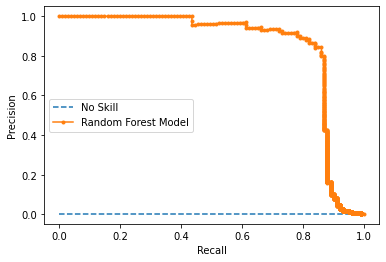

In [18]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Random Forest Model')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [21]:
print(accuracy_score(y_test, yhat)*100, '% of accuracy!!! ')

99.94557775359011 % of accuracy!!! 


### 4. Here we need to focus on *recall* metric, because we want the least amount of false negative results possible. Now for SVM with kernel RBF:

In [22]:
search_svm = GridSearchCV(pipeline_svm, param_grid_svm, n_jobs=-1, scoring='recall') # by defaul it creates a 5-fold cross-validation
search_svm.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaller', StandardScaler()),
                                       ('classifier',
                                        SVC(probability=True,
                                            random_state=7))]),
             n_jobs=-1,
             param_grid={'classifier__C': [1, 10, 100],
                         'classifier__gamma': [0.001, 0.0001]},
             scoring='recall')

In [23]:
search_svm.best_params_

{'classifier__C': 100, 'classifier__gamma': 0.0001}

In [24]:
predictor_svm = search_svm.best_estimator_

In [25]:
predictor_svm

Pipeline(steps=[('scaller', StandardScaler()),
                ('classifier',
                 SVC(C=100, gamma=0.0001, probability=True, random_state=7))])

In [26]:
# predict probabilities
lr_probs_svm = predictor_svm.predict_proba(X_test)

In [27]:
# keep probabilities for the positive outcome only
lr_probs_svm = lr_probs_svm[:, 1]

# predict class values
yhat_svm = predictor_svm.predict(X_test)


lr_precision_svm, lr_recall_svm, _ = precision_recall_curve(y_test, lr_probs_svm)

lr_f1_svm, lr_auc_svm = f1_score(y_test, yhat_svm), auc(lr_recall_svm, lr_precision_svm)

In [28]:
# summarize scores
print('Random Forest Model', ': f1=%.3f auc=%.3f' % (lr_f1_svm, lr_auc_svm))

Random Forest Model : f1=0.816 auc=0.818


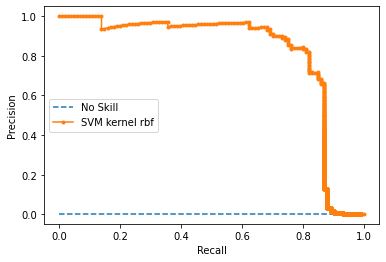

In [29]:
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall_svm, lr_precision_svm, marker='.', label='SVM kernel rbf')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [30]:
print(accuracy_score(y_test, yhat_svm)*100, '% of accuracy!!! ')

99.93504441557529 % of accuracy!!! 


In [32]:
metrics_models = {'Random Forest':['99.95%', 0.85, 0.832], 'SVM-rbf':['99.94%', 0.818, 0.816]}

In [33]:
metrics_modelsd_df = pd.DataFrame(metrics_models)

In [37]:
metrics_modelsd_df.rename(index={0: 'acc', 1: 'AUC', 2: 'f1-score'}, inplace=True)

In [38]:
metrics_modelsd_df

,Random Forest,SVM-rbf
acc,99.95%,99.94%
AUC,0.85,0.818
f1-score,0.832,0.816
